In [1]:
import gym
from gym.wrappers import Monitor
from collections import deque
import tensorflow as tf
import numpy as np
import random
import math
import time
import glob
import io
import base64
import matplotlib.pyplot as plt 
from IPython.display import HTML
from IPython import display as ipythondisplay

In [2]:
# TRAINING
N_EPISODES = 1000

# AGENT HYPERPARAMETERS
EXPLORATION_RATIO = 1.0
LEARNING_RATE = 0.2
DISCOUNT_FACTOR = 0.99
E_DECAY_LIMIT = 0.05
E_DECAY_RATE = 0.001
BATCH_SIZE = 32
MEM_BUFFER = 100000
FRAMES_2_TARGET = 2000

# MISC
REPORT_FILE = False
STEPS_REPORT = 50

config = {
    "n_episodes": N_EPISODES,
    "exploration_ratio": EXPLORATION_RATIO,
    "learning_rate": LEARNING_RATE,
    "discount_factor": DISCOUNT_FACTOR,
    "e_decay_limit": E_DECAY_LIMIT,
    "e_decay_rate": E_DECAY_RATE,
    "report_file": REPORT_FILE
}

env = gym.make('CartPole-v1')
NUM_FEATURES = env.observation_space.shape[0]
NUM_ACTIONS = env.action_space.n
print('Number of state features: {}'.format(NUM_FEATURES))
print('Number of possible actions: {}'.format(NUM_ACTIONS))

Number of state features: 4
Number of possible actions: 2


In [3]:
class DQN(tf.keras.Model):
    def __init__(self):
        super(DQN, self).__init__()
        self.dense1 = tf.keras.layers.Dense(32, activation="relu")
        self.dense2 = tf.keras.layers.Dense(32, activation="relu")
        self.dense3 = tf.keras.layers.Dense(NUM_ACTIONS, dtype=tf.float32) # No activation
    
    def call(self, x):
        x = self.dense1(x)
        x = self.dense2(x)
        return self.dense3(x)

main_nn = DQN()
target_nn = DQN()

optimizer = tf.keras.optimizers.Adam(1e-4)
mse = tf.keras.losses.MeanSquaredError()

2022-01-21 00:56:08.049955: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [4]:
class ReplayBuffer(object):
    def __init__(self, size):
        self.buffer = deque(maxlen=size)

    def add(self, state, action, reward, next_state, done):
        self.buffer.append((state, action, reward, next_state, done))

    def __len__(self):
        return len(self.buffer)

    def sample(self, num_samples):
        states, actions, rewards, next_states, dones = [], [], [], [], []
        idx = np.random.choice(len(self.buffer), num_samples)
        for i in idx:
            elem = self.buffer[i]
            state, action, reward, next_state, done = elem
            states.append(np.array(state, copy=False))
            actions.append(np.array(action, copy=False))
            rewards.append(reward)
            next_states.append(np.array(next_state, copy=False))
            dones.append(done)
        states = np.array(states)
        actions = np.array(actions)
        rewards = np.array(rewards, dtype=np.float32)
        next_states = np.array(next_states)
        dones = np.array(dones, dtype=np.float32)
        return states, actions, rewards, next_states, dones

In [5]:
def select_epsilon_greedy_action(state, epsilon):
    """Take random action with probability epsilon, else take best action."""
    result = tf.random.uniform((1,))
    if result < epsilon:
        return env.action_space.sample() # Random action (left or right).
    else:
        return tf.argmax(main_nn(state)[0]).numpy() # Greedy action for state.

In [6]:
@tf.function
def train_step(states, actions, rewards, next_states, dones):
    """Perform a training iteration on a batch of data sampled from the experience replay buffer."""
    # Calculate targets.
    next_qs = target_nn(next_states)
    max_next_qs = tf.reduce_max(next_qs, axis=-1)
    target = rewards + (1. - dones) * DISCOUNT_FACTOR * max_next_qs
    with tf.GradientTape() as tape:
        qs = main_nn(states)
        action_masks = tf.one_hot(actions, NUM_ACTIONS)
        masked_qs = tf.reduce_sum(action_masks * qs, axis=-1)
        loss = mse(target, masked_qs)
    grads = tape.gradient(loss, main_nn.trainable_variables)
    optimizer.apply_gradients(zip(grads, main_nn.trainable_variables))
    return loss

In [7]:
# Traning
buffer = ReplayBuffer(MEM_BUFFER)
cur_frame = 0

# Start training. Play game once and then train with a batch.
last_100_ep_rewards = []
reward_hist = []
for episode in range(N_EPISODES+1):
    state = env.reset()
    ep_reward, done = 0, False
    while not done:
        state_in = tf.expand_dims(state, axis=0)
        action = select_epsilon_greedy_action(state_in, EXPLORATION_RATIO)
        next_state, reward, done, info = env.step(action)
        ep_reward += reward
        # Save to experience replay.
        buffer.add(state, action, reward, next_state, done)
        state = next_state
        cur_frame += 1
        # Copy main_nn weights to target_nn.
        if cur_frame % FRAMES_2_TARGET == 0:
            target_nn.set_weights(main_nn.get_weights())

        # Train neural network.
        if len(buffer) >= BATCH_SIZE:
            states, actions, rewards, next_states, dones = buffer.sample(BATCH_SIZE)
            loss = train_step(states, actions, rewards, next_states, dones)
  
    if E_DECAY_LIMIT < EXPLORATION_RATIO:
        EXPLORATION_RATIO -= E_DECAY_RATE

    if len(last_100_ep_rewards) == 100:
        last_100_ep_rewards = last_100_ep_rewards[1:]
    last_100_ep_rewards.append(ep_reward)
    reward_hist.append(ep_reward)

    
    if episode % STEPS_REPORT == 0:
        print(f'Episode {episode}/{N_EPISODES}. Epsilon: {EXPLORATION_RATIO:.3f}. 'f'Reward in last 100 episodes: {np.mean(last_100_ep_rewards):.3f}')
env.close()

Episode 0/1000. Epsilon: 0.999. Reward in last 100 episodes: 38.000
Episode 50/1000. Epsilon: 0.949. Reward in last 100 episodes: 23.804
Episode 100/1000. Epsilon: 0.899. Reward in last 100 episodes: 22.520
Episode 150/1000. Epsilon: 0.849. Reward in last 100 episodes: 19.830
Episode 200/1000. Epsilon: 0.799. Reward in last 100 episodes: 17.540
Episode 250/1000. Epsilon: 0.749. Reward in last 100 episodes: 16.930
Episode 300/1000. Epsilon: 0.699. Reward in last 100 episodes: 16.390
Episode 350/1000. Epsilon: 0.649. Reward in last 100 episodes: 20.130
Episode 400/1000. Epsilon: 0.599. Reward in last 100 episodes: 29.120
Episode 450/1000. Epsilon: 0.549. Reward in last 100 episodes: 49.300
Episode 500/1000. Epsilon: 0.499. Reward in last 100 episodes: 85.850
Episode 550/1000. Epsilon: 0.449. Reward in last 100 episodes: 133.050
Episode 600/1000. Epsilon: 0.399. Reward in last 100 episodes: 168.130
Episode 650/1000. Epsilon: 0.349. Reward in last 100 episodes: 196.430
Episode 700/1000. Ep

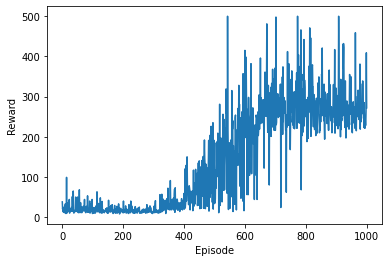

In [8]:
plt.plot(reward_hist)
plt.xlabel("Episode")
plt.ylabel("Reward")
plt.show()

In [9]:
def show_video():
    mp4list = glob.glob('resources/videos/cartpoledqn/*.mp4')
    if len(mp4list) > 0:
        mp4 = mp4list[0]
        video = io.open(mp4, 'r+b').read()
        encoded = base64.b64encode(video)
        ipythondisplay.display(HTML(data='''<video alt="test" autoplay 
                loop controls style="height: 400px;">
                <source src="data:video/mp4;base64,{0}" type="video/mp4" />
             </video>'''.format(encoded.decode('ascii'))))
    else: 
        print("Video not found")
    

def wrap_env(env):
    env = Monitor(env, './resources/videos/cartpoledqn', force=True)
    return env

In [13]:
env = wrap_env(gym.make('CartPole-v1'))
state = env.reset()
done = False
ep_rew = 0
while not done:
    env.render()
    state = tf.expand_dims(state, axis=0)
    action = select_epsilon_greedy_action(state, epsilon=0)
    state, reward, done, info = env.step(action)
    ep_rew += reward
print('Episode reward was {}'.format(ep_rew))
env.close()
show_video()

Episode reward was 356.0
